### Import dependencies

In [2]:
%load_ext autoreload
%autoreload 2
import os

import requests
import numpy as np
import pandas as pd
import numpy_ext as npext

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch

import plots as plot
from plots import Style, colormap, configure_axis 

# Stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Fetch datasets

In [3]:
DATASETS_URL = 'https://storage.googleapis.com/3jane-articles/datasets/1-autocorrelation'


def get_dataset(dataset, dataset_dir='datasets', force_download=False):
    if not os.path.exists(dataset_dir):
        os.mkdir(dataset_dir)
    
    dataset_path = os.path.join(dataset_dir, dataset)
    
    if force_download or not os.path.exists(dataset_path):
        r = requests.get(f'{DATASETS_URL}/{dataset}')
        r.raise_for_status()
        with open(dataset_path, 'wb') as dest_file:
            dest_file.write(r.content)
    
    return pd.read_hdf(dataset_path, key='table')

In [5]:
###
# NOTE:
# The notebook is designed to run all experiments in the article for one dataset.
# Select the dataset you would like to explore, uncomments it's line, comment the rest. 
# Each dataset takes up about 100-150MB of disk space.
# It will be downloaded and cached into `/datasets/` folder.
# The download might take a while depeding on the speed of your internet connection.
###

raw_data = get_dataset('BTC_USD_bitfinex_1m.hdf')
# raw_data = get_dataset('ETH_BTC_bitfinex_1m.hdf')
# raw_data = get_dataset('ETH_USD_bitfinex_1m.hdf')
# raw_data = get_dataset('XBT_USD_bitmex_1m.hdf')

raw_data

,open,high,low,close,volume
timestamp,,,,,
2016-03-09 18:15:00,0.025770,0.025770,0.025770,0.025770,0.010000
2016-03-09 19:04:00,0.025500,0.025500,0.025200,0.025300,3.264000
2016-03-09 20:17:00,0.025700,0.025700,0.025700,0.025700,0.010000
2016-03-09 22:15:00,0.026900,0.027900,0.026300,0.027900,20.000000
2016-03-09 22:17:00,0.027900,0.029700,0.027900,0.029500,12.376000
...,...,...,...,...,...
2019-06-30 23:55:00,0.027031,0.027078,0.026995,0.027038,250.122526
2019-06-30 23:56:00,0.027040,0.027040,0.027040,0.027040,0.400000
2019-06-30 23:57:00,0.027031,0.027063,0.027031,0.027031,9.596427


### Aggregate 1m bars into 5m, 1H, 1D and 1W timeframes

In [8]:
def time_consolidator(df, period):
    aggregate = {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum',
    }
    return df.resample(f'{period}S').agg(aggregate).dropna()


def add_basic_features(df):
    bars = df.copy()
    bars['date'] = df.index.strftime('%Y-%m-%d')
    bars['change'] = bars.close / bars.open - 1
    return bars


bars_5m = time_consolidator(raw_data, 60*5)
bars_1H = time_consolidator(raw_data, 60*60)
bars_1D = time_consolidator(raw_data, 60*60*24)
bars_1W = time_consolidator(raw_data, 60*60*24*7)

bars_5m = add_basic_features(bars_5m)
bars_1H = add_basic_features(bars_1H)
bars_1D = add_basic_features(bars_1D)
bars_1W = add_basic_features(bars_1W)

datasets = {
    '5m': bars_5m, 
    '1H': bars_1H, 
    '1D': bars_1D,
    '1W': bars_1W,
}

mindate, maxdate = bars_5m.date[0], bars_5m.date[-1]

### Plot Pearson's autocorrelation coefficient of different orders on all four timeframes

In [9]:
def plot_acorr(series, nlags, alpha, title, ax):
    corr, alpha = acf(series, nlags=nlags, alpha=alpha, fft=True)
    corr = corr[1:] # drop first element with corr=1
    x = np.array(range(1, corr.size+1))
    conf_int = (alpha[:,0][1:] - corr, alpha[:,1][1:] - corr)
    
    corr_strs = [f'{c:.4f}' for c in corr]
    plot.area(y1=conf_int[0], y2=conf_int[1], x=x, style=Style(fill_alpha=0.05), ax=ax)
    plot.bars(y=corr, x=x, title=title, ylabel='Correlation', xlabel='Lags', ax=ax)
    ticks = list(range(1, nlags+1, 2))
    ax.set_xticks(ticks)
    ax.set_xticklabels([str(xi) for xi in ticks])

CPU times: user 1.06 s, sys: 134 ms, total: 1.2 s
Wall time: 968 ms


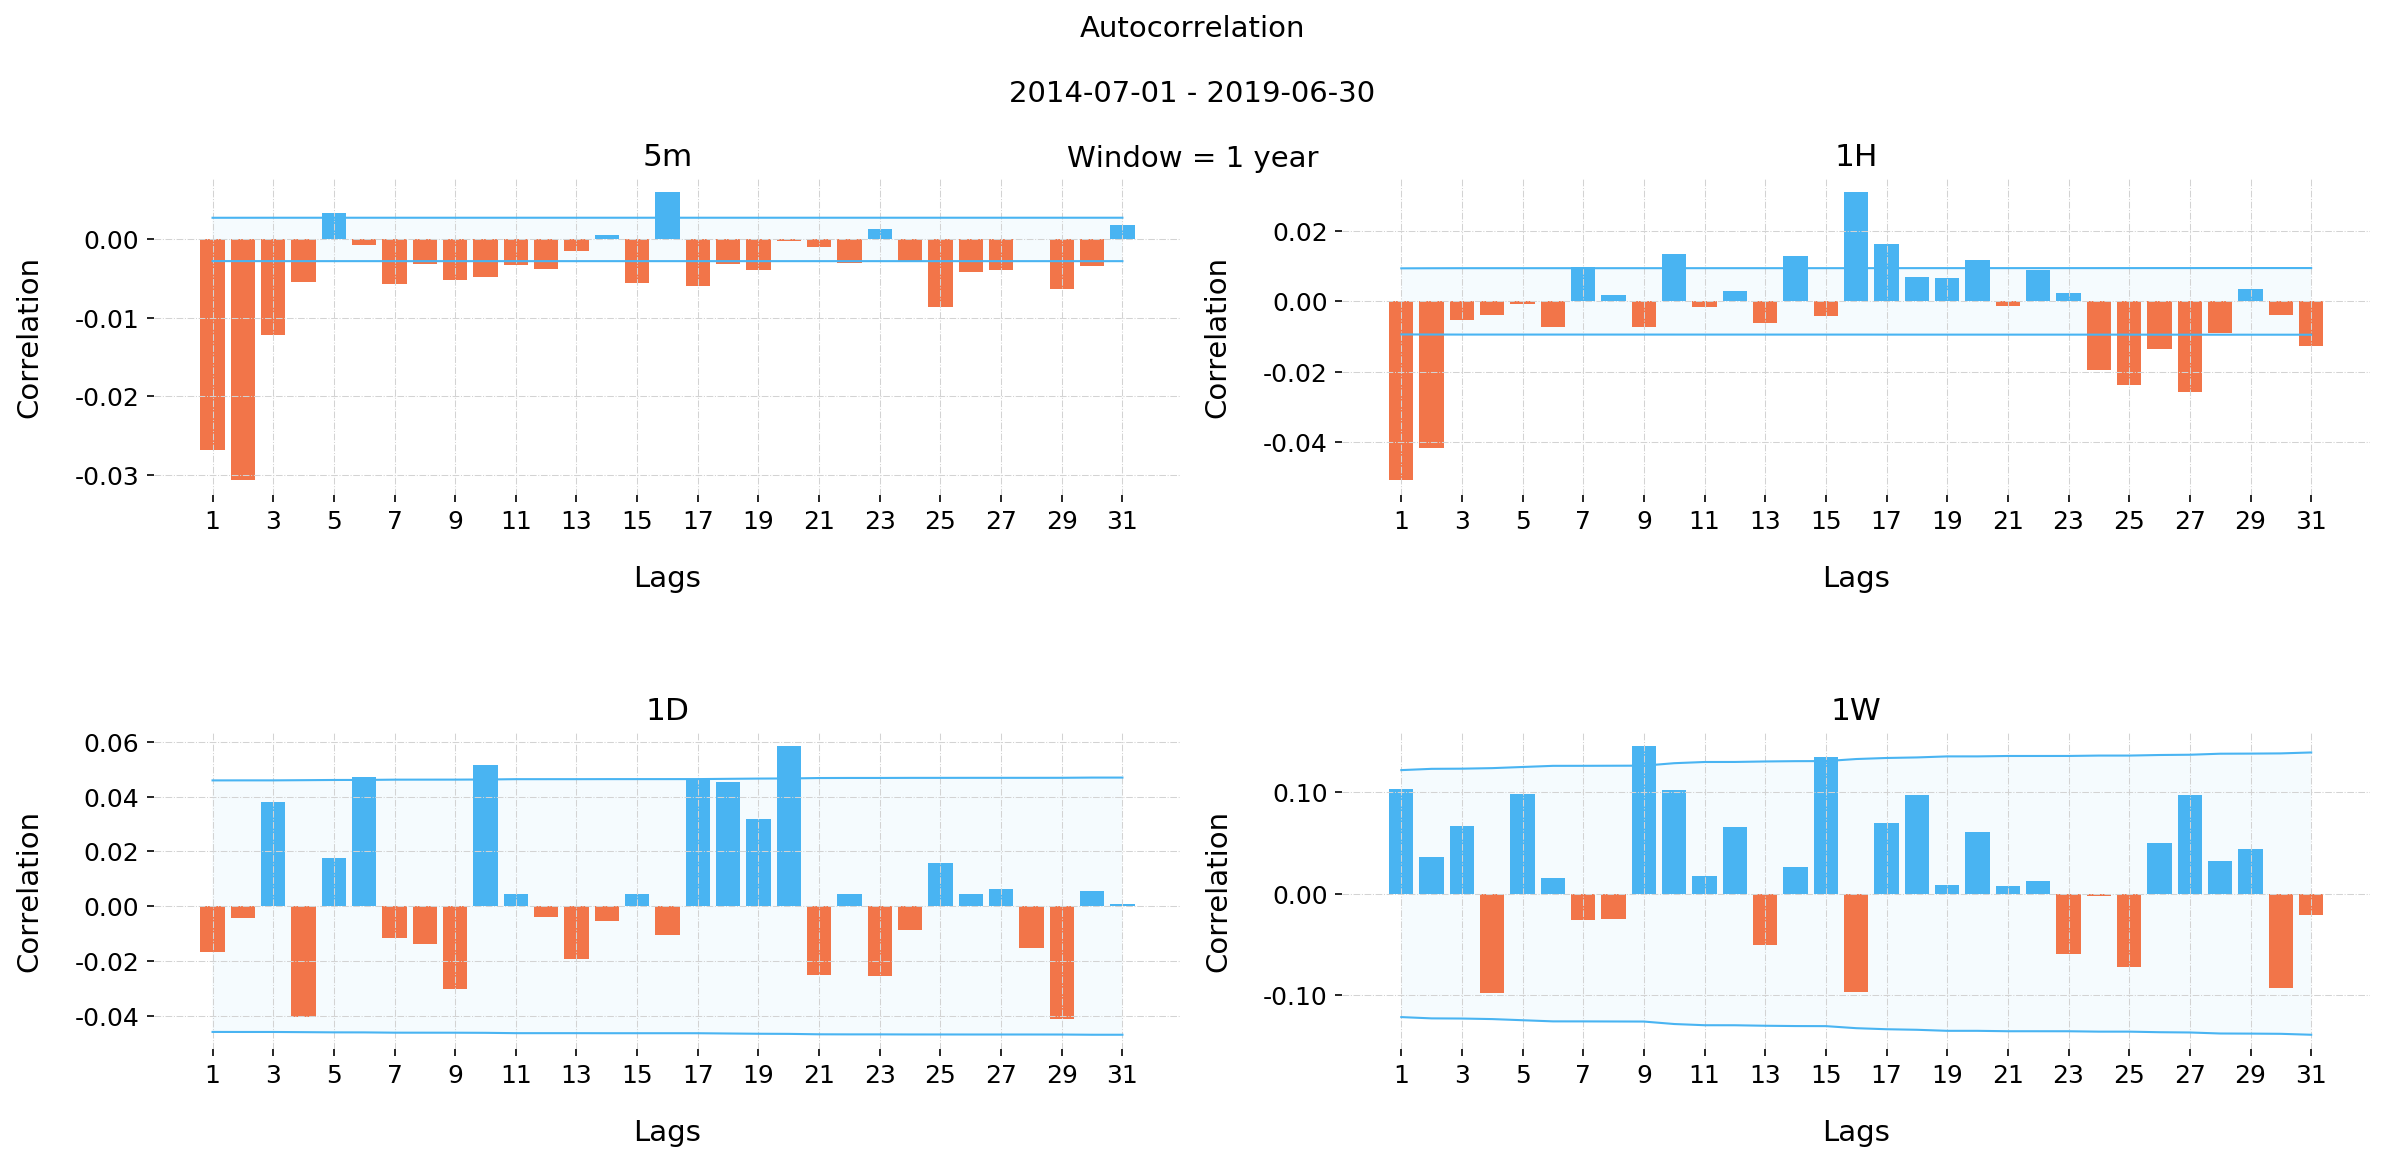

In [11]:
%%time


# Calculate and plot results
fig, axes = plt.subplots(2, 2, figsize=(16, 7), dpi=150, facecolor='w')
axes = axes.ravel()
fig.suptitle(f'Autocorrelation\n\n{mindate} - {maxdate}\n\nWindow = 1 year', y=1.1, fontsize=14)

for i, (k, v) in enumerate(datasets.items()):
    plot_acorr(v['change'], title=k, nlags=31, alpha=0.05, ax=axes[i])

fig.tight_layout(h_pad=5)

### Plot p-values of Ljung-Box test on 1H and 1W timeframes

CPU times: user 18min 34s, sys: 30min 20s, total: 48min 55s
Wall time: 1min 1s


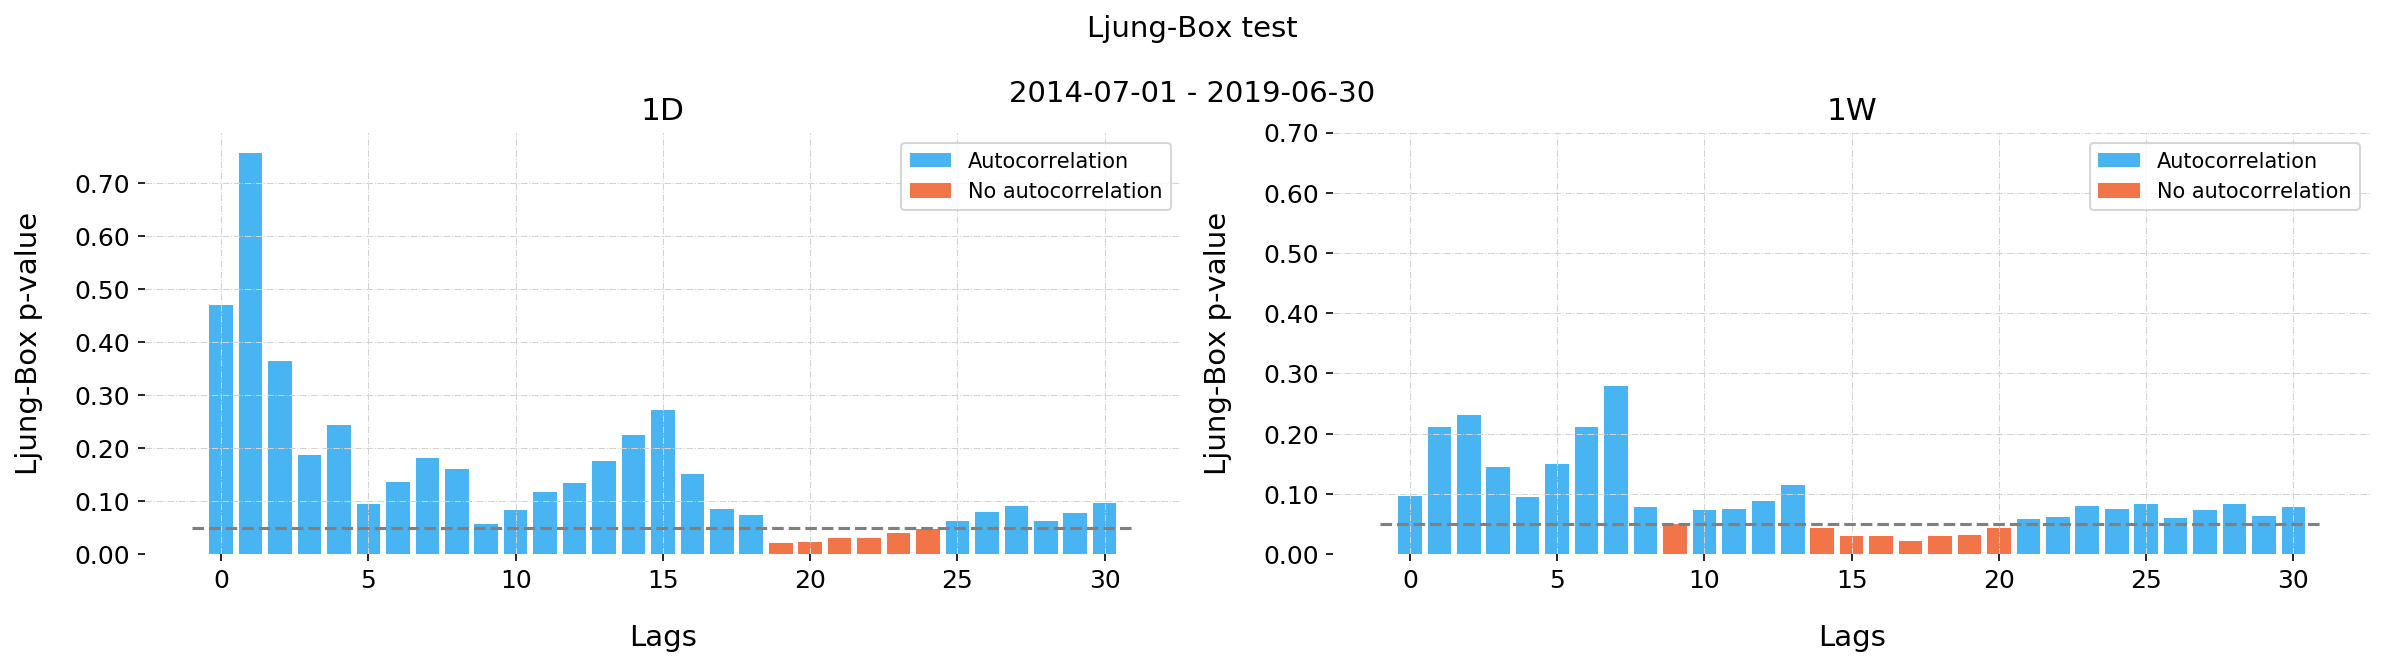

In [7]:
###
# NOTE: 
# Takes about 1 minute to calculate on 24-core machine
###

%%time

# Set parameters
lb_lags = 31
threshold = 0.05

plot_starting_with_i = 2

# Calculate and plot results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), dpi=150, facecolor='w')
axes = axes.ravel()
fig.suptitle(f'Ljung-Box test\n\n{mindate} - {maxdate}', y=1.1, fontsize=14)

for i, (k, v) in enumerate(datasets.items()):
    p_vals = acorr_ljungbox(v['change'], lags=lb_lags)[1]

    p_strs = [f'{p:.3f}' for p in p_vals]
    
    if i >= plot_starting_with_i:
        axid = i-plot_starting_with_i
        above = np.where(p_vals >= threshold, p_vals, 0)
        below = np.where(p_vals < threshold, p_vals, 0)

        plot.bars(above, threshold=0,  ax=axes[axid], pos_legend_label='Autocorrelation')
        plot.bars(below, threshold=0, title=k, xlabel='Lags', ylabel='Ljung-Box p-value', 
                  ax=axes[axid], pos_color = colormap(0.045), pos_legend_label='No autocorrelation')
        axes[axid].legend()
        axes[axid].plot([-1, lb_lags], [threshold, threshold], "k--", color='grey')
        
        axes[axid].yaxis.set_ticks(np.arange(0, 0.8, 0.1))
    
fig.tight_layout(h_pad=3)

### Plot first-order Pearson's autocorrelation coefficient in a rolling 1-year window on all timeframes

In [8]:
def np_racorr(series, window, lag):
    return npext.drop_na(
        npext.rolling_apply(
            lambda series, lag: acf(series, nlags=lag, fft=True)[lag],
            window,
            series.values,
            lag=lag,
            n_jobs=24
        )
    )

CPU times: user 14min 45s, sys: 3min 35s, total: 18min 20s
Wall time: 21min 8s


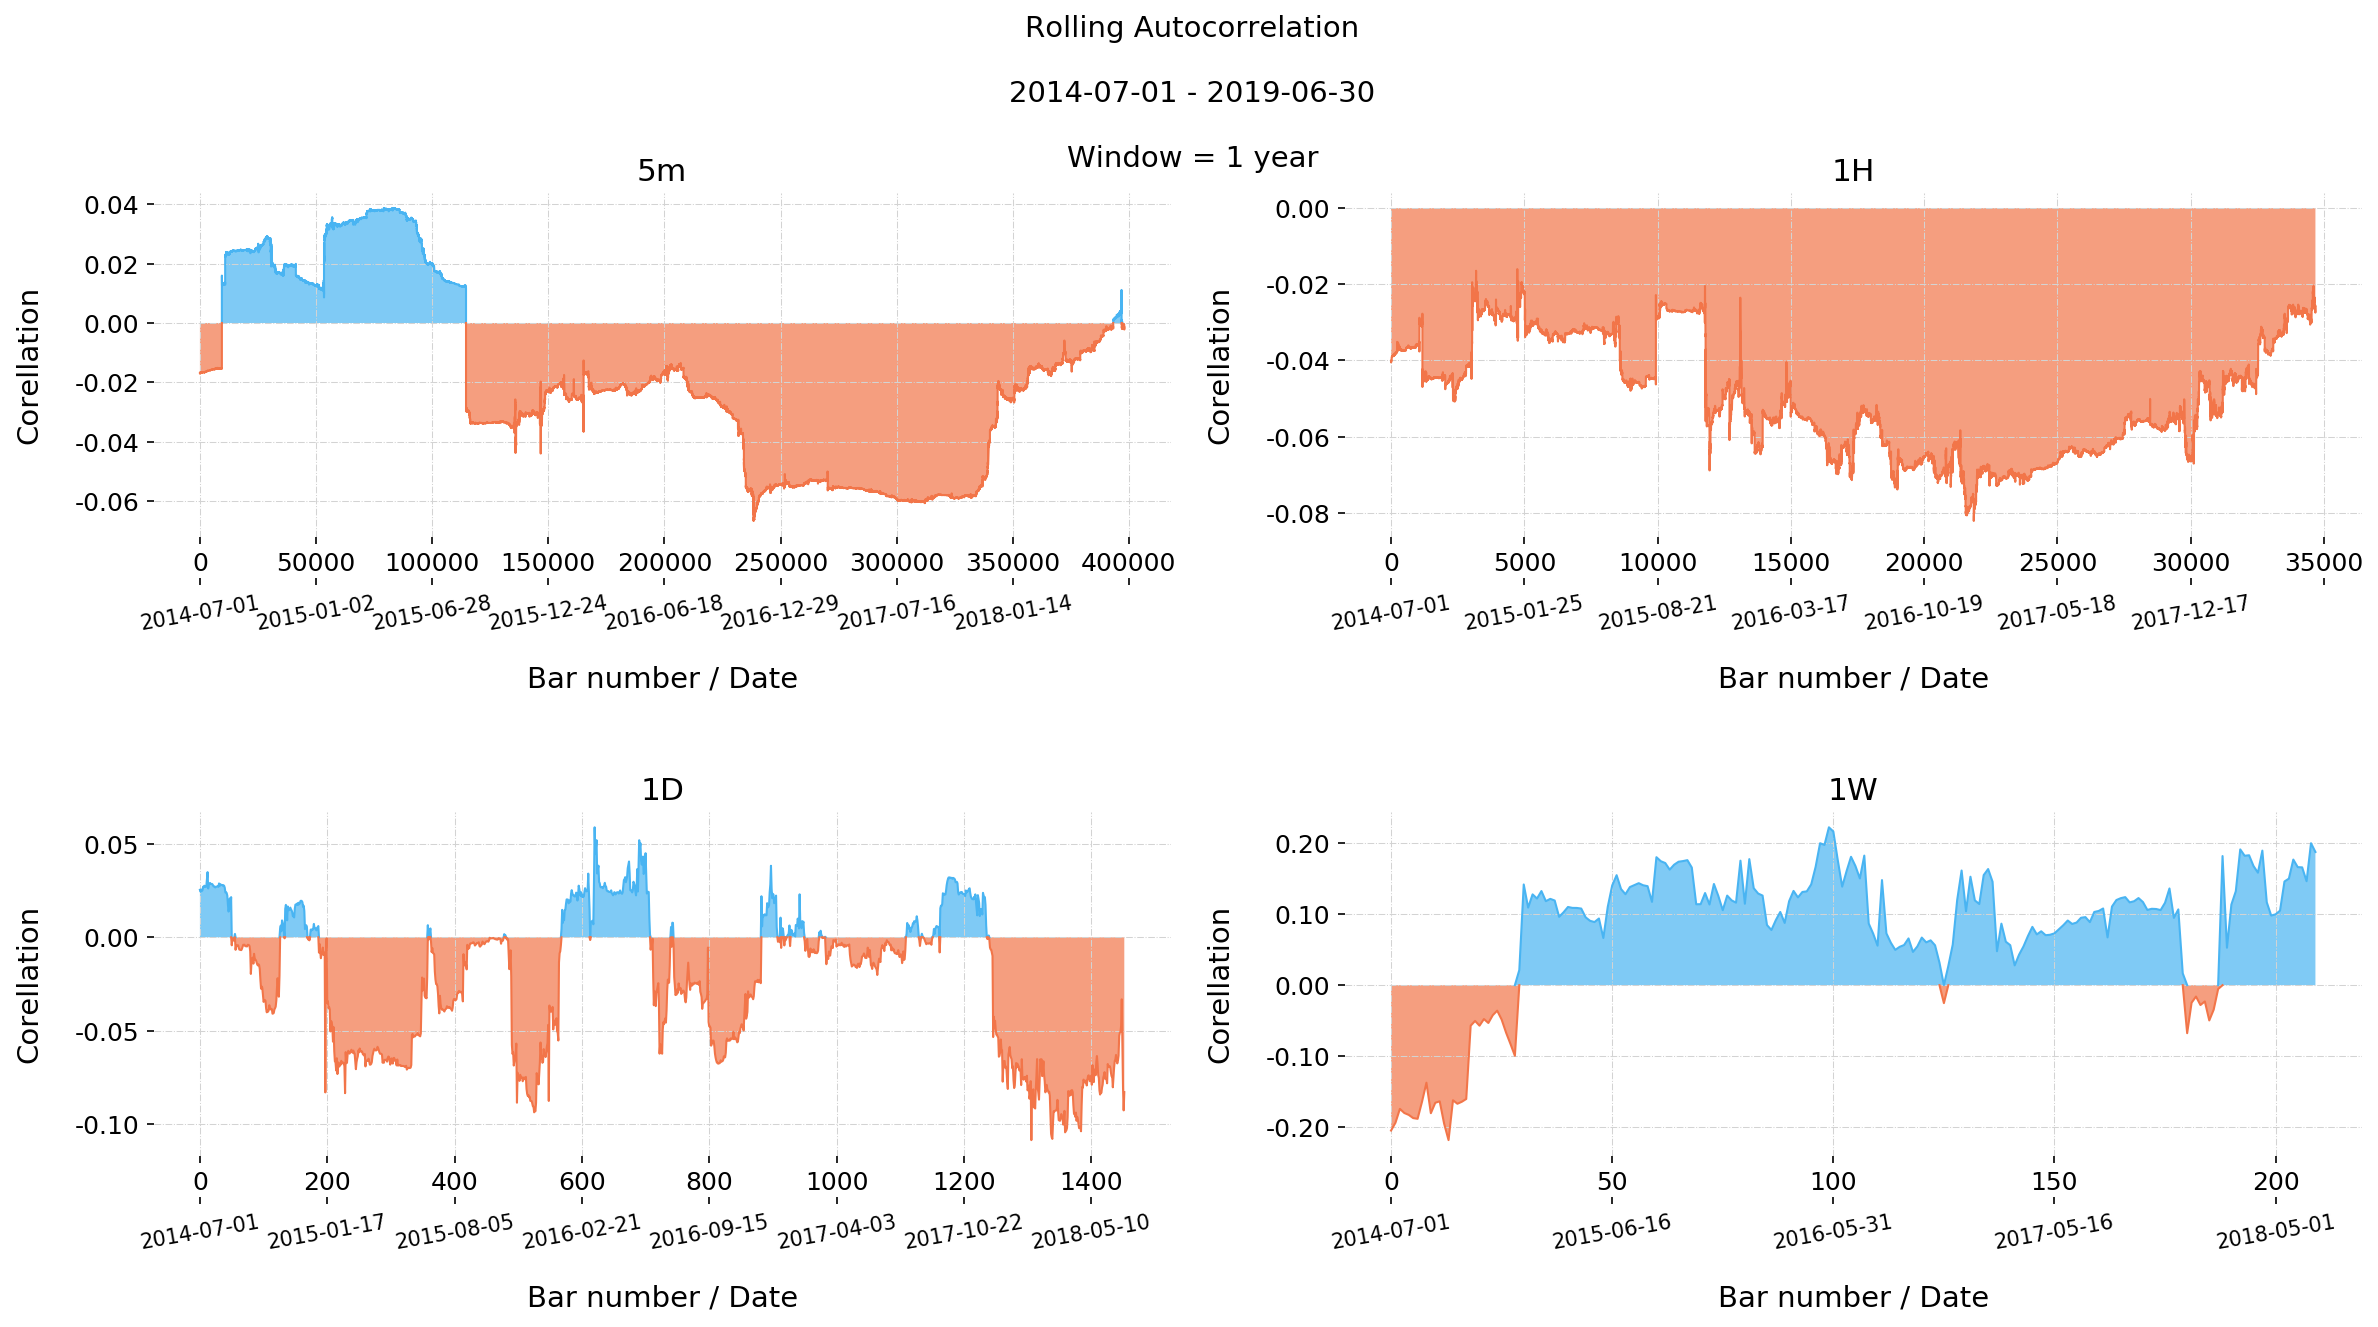

In [9]:
###
# NOTE: 
# Takes about 20 minutes to calculate on 24-core machine
###

%%time

# Set parameters
lag = 1
windows = [
    365*24*12, # 5m bars in 1 year
    365*24,  # 1H bars in 1 year
    365, # 1D bars in 1 year
    52 # 1W bars in 1 year
] 

# Calculate and plot results
fig, axes = plt.subplots(2, 2, figsize=(16, 8), dpi=150, facecolor='w')
axes = axes.ravel()
fig.suptitle(f'Rolling Autocorrelation\n\n{mindate} - {maxdate}\n\nWindow = 1 year', y=1.1, fontsize=14)

for i, (k, v) in enumerate(datasets.items()):
    w = windows[i]
    s = v['change']
    
    ra = np_racorr(s, w, lag)
    plot.curve(ra, title=k, style=Style(fill=True), ax=axes[i], ylabel='Corellation')
    plot.second_index(axes[i], v['date'], xlabel='Bar number / Date', rotation=10)

fig.tight_layout(h_pad=4)